<div style="background-color: darkred; color: white; padding: 10px; border-radius: 5px; text-align: center; font-size: 20px;">
    HEART ATTACK RISK PREDICTION
</div>


<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title></title>
</head>
<body>
    <div style="border: 1px solid #000000; border-radius: 5px; padding: 5px; background-color: #FFFFFF; font-family: 'Verdana', sans-serif; line-height: 1.5; word-wrap: break-word;">
        <h1 style="color: #000000; text-align: left; font-size: 18px; font-weight: bold; margin: 5px 0;">PURPOSE</h1>
        <p style="font-size: 14px; color: #000000; margin: 10px 0 5px;">
            In this study, many factors were examined to understand heart health and heart attack risk. In addition to medical information such as patients' cholesterol levels, blood pressure, heart rate, previous heart problems, medication use and triglycerides, lifestyle factors such as smoking and alcohol consumption, exercise, nutrition and stress were also included. Socioeconomic and geographical factors were also included. This study aims to identify strategies for the prevention and management of heart attack risk using machine learning.

</body>
</html>


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc


import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

df_ = pd.read_csv("/kaggle/input/heart-attack-prediction-dataset/heart_attack_prediction_dataset.csv")
df = df_.copy()
df.head()

,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,0,4.168189,Average,0,0,9,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,1,1.813242,Unhealthy,1,0,1,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,0,2.078353,Healthy,1,1,9,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,1,9.828130,Average,1,0,9,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,0,5.804299,Unhealthy,1,0,6,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0


<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title></title>
</head>
<body>
    <div style="border: 1px solid #000000; border-radius: 5px; padding: 5px; background-color: #FFFFFF; font-family: 'Verdana', sans-serif; line-height: 1.5; word-wrap: break-word;">
        <h1 style="color: #000000; text-align: left; font-size: 18px; font-weight: bold; margin: 5px 0;">EXPLORATORY DATA ANALYSIS</h1>
    </div>
</body>
</html>


In [3]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    #num_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["int64", "float64"]]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 8763
Variables: 26
cat_cols: 15
num_cols: 9
cat_but_car: 2
num_but_cat: 10


         Sex      Ratio
Sex                    
Male    6111  69.736392
Female  2652  30.263608
##########################################


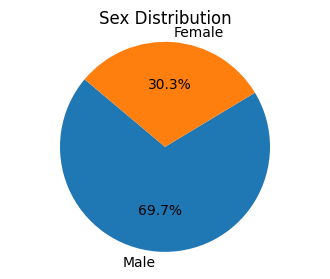

           Diet      Ratio
Diet                      
Healthy    2960  33.778386
Average    2912  33.230629
Unhealthy  2891  32.990985
##########################################


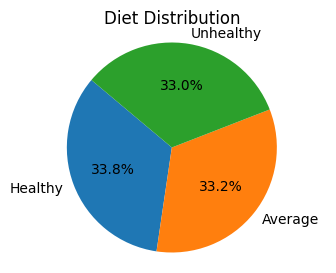

                Country     Ratio
Country                          
Germany             477  5.443341
Argentina           471  5.374872
Brazil              462  5.272167
United Kingdom      457  5.215109
Australia           449  5.123816
Nigeria             448  5.112404
France              446  5.089581
Canada              440  5.021111
China               436  4.975465
New Zealand         435  4.964053
Japan               433  4.941230
Italy               431  4.918407
Spain               430  4.906995
Colombia            429  4.895584
Thailand            428  4.884172
South Africa        425  4.849937
Vietnam             425  4.849937
United States       420  4.792879
India               412  4.701586
South Korea         409  4.667351
##########################################


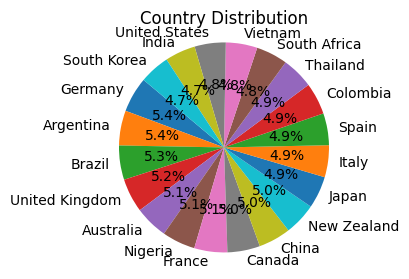

               Continent      Ratio
Continent                          
Asia                2543  29.019742
Europe              2241  25.573434
South America       1362  15.542622
Australia            884  10.087869
Africa               873   9.962342
North America        860   9.813991
##########################################


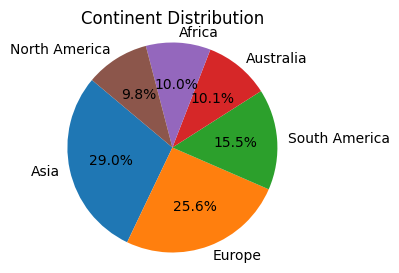

                     Hemisphere      Ratio
Hemisphere                                
Northern Hemisphere        5660  64.589752
Southern Hemisphere        3103  35.410248
##########################################


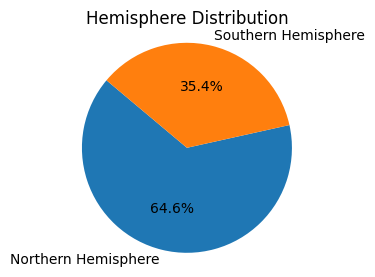

          Diabetes      Ratio
Diabetes                     
1             5716  65.228803
0             3047  34.771197
##########################################


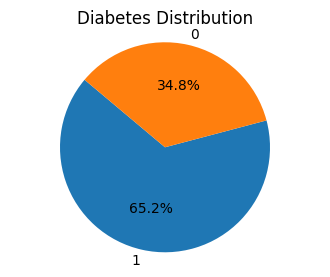

                Family History      Ratio
Family History                           
0                         4443  50.701814
1                         4320  49.298186
##########################################


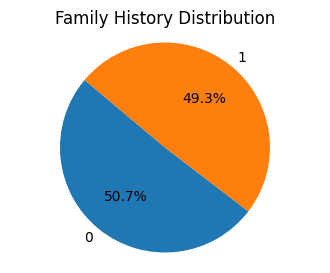

         Smoking      Ratio
Smoking                    
1           7859  89.683898
0            904  10.316102
##########################################


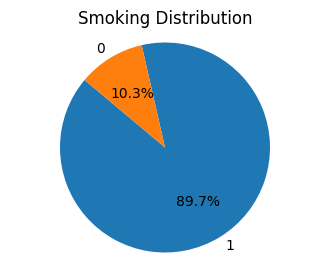

         Obesity      Ratio
Obesity                    
1           4394  50.142645
0           4369  49.857355
##########################################


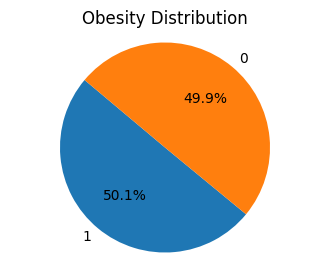

                     Alcohol Consumption      Ratio
Alcohol Consumption                                
1                                   5241  59.808285
0                                   3522  40.191715
##########################################


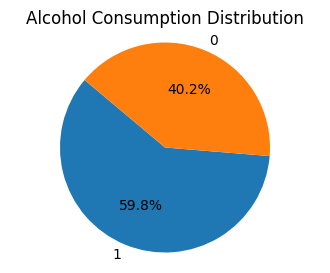

                         Previous Heart Problems      Ratio
Previous Heart Problems                                    
0                                           4418  50.416524
1                                           4345  49.583476
##########################################


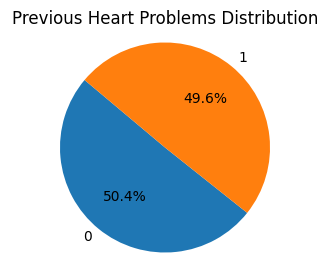

                Medication Use      Ratio
Medication Use                           
0                         4396  50.165468
1                         4367  49.834532
##########################################


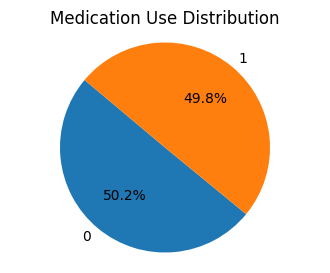

                                 Physical Activity Days Per Week      Ratio
Physical Activity Days Per Week                                            
3                                                           1143  13.043478
1                                                           1121  12.792423
2                                                           1109  12.655483
7                                                           1095  12.495721
5                                                           1079  12.313135
4                                                           1077  12.290312
6                                                           1074  12.256077
0                                                           1065  12.153372
##########################################


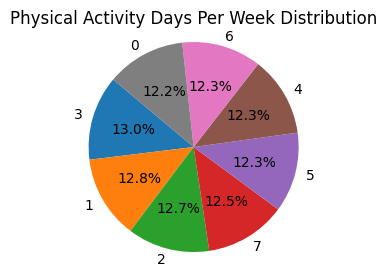

                     Sleep Hours Per Day      Ratio
Sleep Hours Per Day                                
10                                  1293  14.755221
8                                   1288  14.698163
6                                   1276  14.561223
7                                   1270  14.492754
5                                   1263  14.412872
9                                   1192  13.602647
4                                   1181  13.477120
##########################################


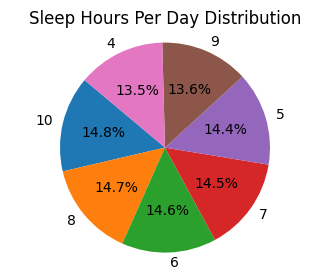

                   Heart Attack Risk      Ratio
Heart Attack Risk                              
0                               5624  64.178934
1                               3139  35.821066
##########################################


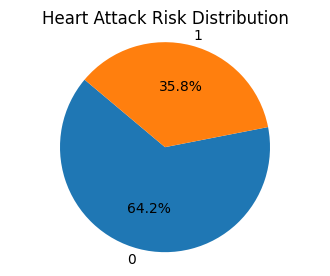

In [4]:
def cat_summary(dataframe, col_name, plot=False):
    summary_df = pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                               "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)})
    print(summary_df)
    print("##########################################")

    if plot:
        plt.figure(figsize=(4, 3))
        plt.pie(summary_df["Ratio"], labels=summary_df.index, autopct='%1.1f%%', startangle=140)
        plt.axis('equal')
        plt.title(f"{col_name} Distribution")
        plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col, True)




count    8763.000000
mean       53.707977
std        21.249509
min        18.000000
5%         21.000000
10%        25.000000
20%        32.000000
30%        39.000000
40%        46.000000
50%        54.000000
60%        61.000000
70%        68.000000
80%        76.000000
90%        83.000000
95%        87.000000
99%        90.000000
max        90.000000
Name: Age, dtype: float64


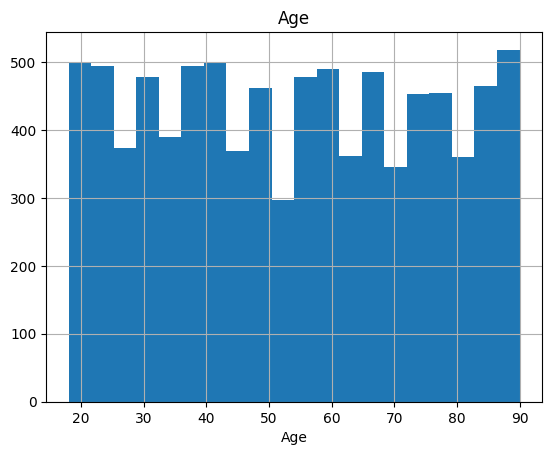

count    8763.000000
mean      259.877211
std        80.863276
min       120.000000
5%        133.000000
10%       148.000000
20%       176.000000
30%       205.000000
40%       234.000000
50%       259.000000
60%       287.000000
70%       315.000000
80%       344.600000
90%       372.000000
95%       385.000000
99%       397.380000
max       400.000000
Name: Cholesterol, dtype: float64


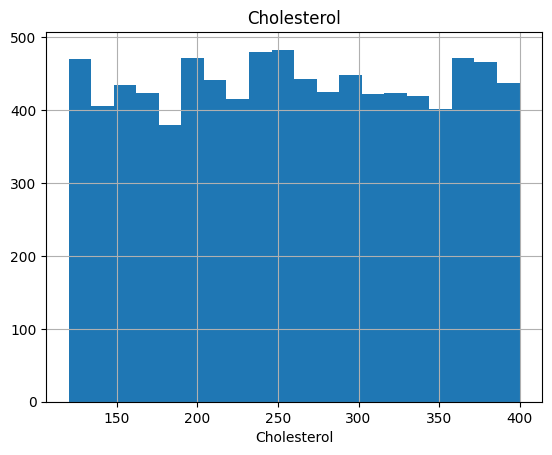

count    8763.000000
mean       75.021682
std        20.550948
min        40.000000
5%         43.000000
10%        46.000000
20%        54.000000
30%        61.000000
40%        68.000000
50%        75.000000
60%        82.000000
70%        89.000000
80%        96.000000
90%       104.000000
95%       107.000000
99%       110.000000
max       110.000000
Name: Heart Rate, dtype: float64


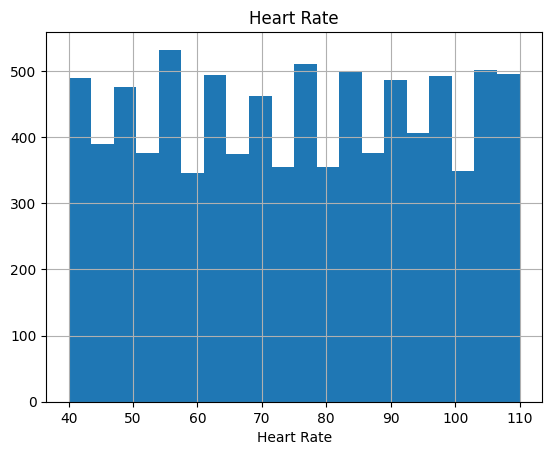

count    8763.000000
mean       10.014284
std         5.783745
min         0.002442
5%          0.934522
10%         2.003155
20%         3.960141
30%         6.017767
40%         8.066594
50%        10.069559
60%        12.067253
70%        13.999178
80%        16.048449
90%        17.960534
95%        18.933262
99%        19.810282
max        19.998709
Name: Exercise Hours Per Week, dtype: float64


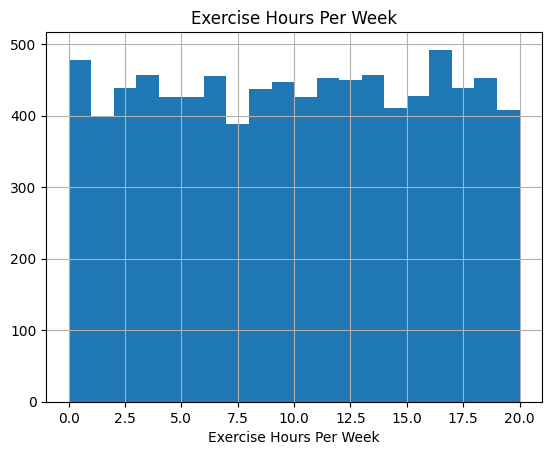

count    8763.000000
mean        5.469702
std         2.859622
min         1.000000
5%          1.000000
10%         2.000000
20%         2.000000
30%         3.000000
40%         4.000000
50%         5.000000
60%         6.000000
70%         7.000000
80%         8.000000
90%         9.000000
95%        10.000000
99%        10.000000
max        10.000000
Name: Stress Level, dtype: float64


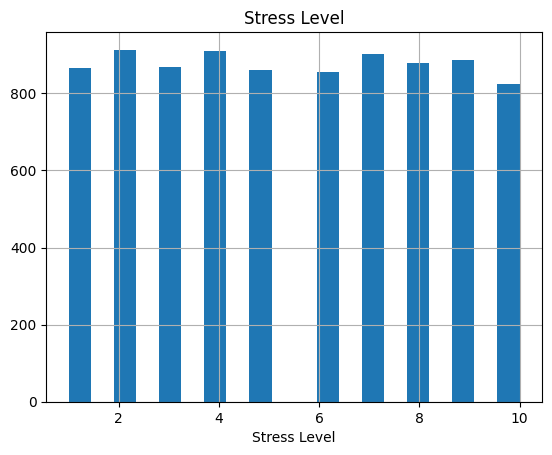

count    8763.000000
mean        5.993690
std         3.466359
min         0.001263
5%          0.613259
10%         1.193243
20%         2.447731
30%         3.630711
40%         4.782563
50%         5.933622
60%         7.099419
70%         8.378003
80%         9.655335
90%        10.808550
95%        11.430435
99%        11.868640
max        11.999313
Name: Sedentary Hours Per Day, dtype: float64


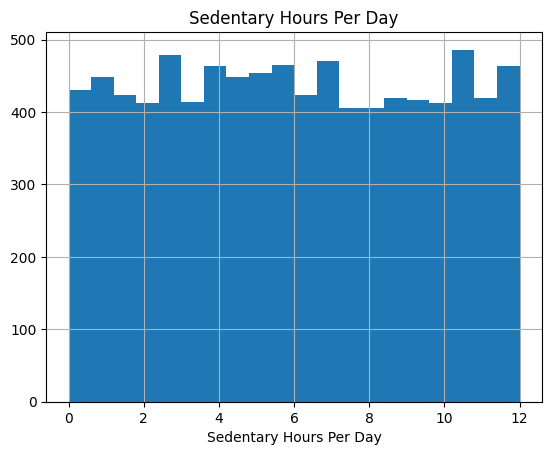

count      8763.000000
mean     158263.181901
std       80575.190806
min       20062.000000
5%        32900.500000
10%       47490.000000
20%       75053.600000
30%      102306.800000
40%      131284.400000
50%      157866.000000
60%      185001.200000
70%      212291.800000
80%      241489.400000
90%      270758.800000
95%      285578.600000
99%      297072.800000
max      299954.000000
Name: Income, dtype: float64


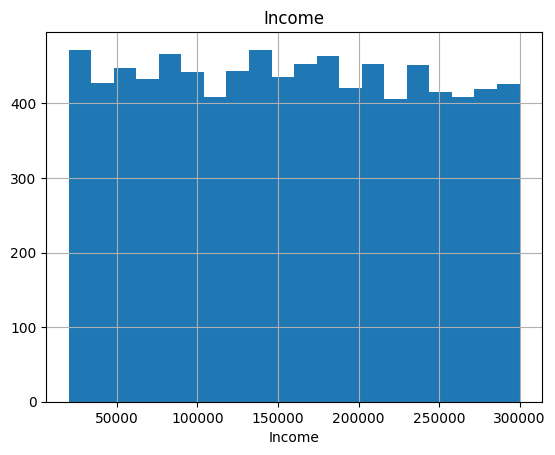

count    8763.000000
mean       28.891446
std         6.319181
min        18.002337
5%         19.106047
10%        20.223227
20%        22.388601
30%        24.455349
40%        26.639528
50%        28.768999
60%        30.938951
70%        33.200891
80%        35.515172
90%        37.784036
95%        38.915325
99%        39.805506
max        39.997211
Name: BMI, dtype: float64


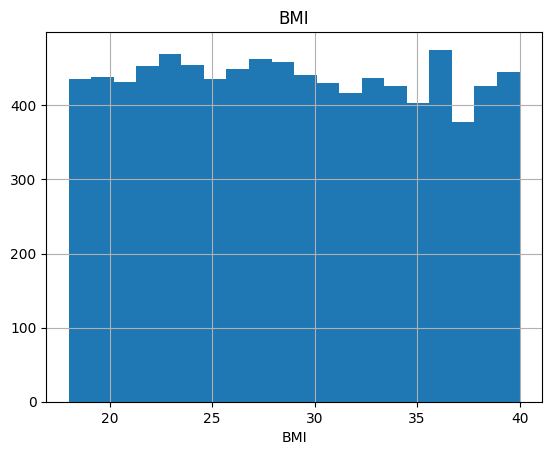

count    8763.000000
mean      417.677051
std       223.748137
min        30.000000
5%         68.000000
10%       104.200000
20%       187.000000
30%       266.000000
40%       340.000000
50%       417.000000
60%       493.000000
70%       572.000000
80%       652.000000
90%       730.000000
95%       766.000000
99%       794.000000
max       800.000000
Name: Triglycerides, dtype: float64


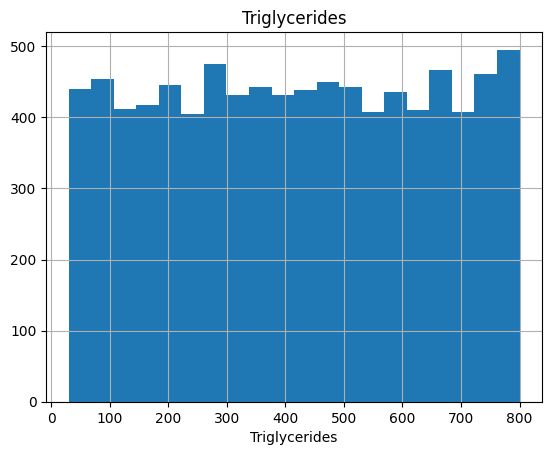

In [5]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)



for col in num_cols:
    num_summary(df, col, plot=True)

In [6]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")


for col in num_cols:
    target_summary_with_num(df, "Heart Attack Risk", col)

                         Age
Heart Attack Risk           
0                  53.606330
1                  53.890092


                   Cholesterol
Heart Attack Risk             
0                   258.708926
1                   261.970373


                   Heart Rate
Heart Attack Risk            
0                   75.086949
1                   74.904747


                   Exercise Hours Per Week
Heart Attack Risk                         
0                                 9.966182
1                                10.100466


                   Stress Level
Heart Attack Risk              
0                      5.478485
1                      5.453966


                   Sedentary Hours Per Day
Heart Attack Risk                         
0                                 6.008225
1                                 5.967648


                          Income
Heart Attack Risk               
0                  157683.662873
1                  159301.479133


                      

In [7]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")


for col in cat_cols:
    target_summary_with_cat(df, "Heart Attack Risk", col)

        TARGET_MEAN
Sex                
Female     0.355958
Male       0.359188


           TARGET_MEAN
Diet                  
Average       0.352335
Healthy       0.364527
Unhealthy     0.357662


                TARGET_MEAN
Country                    
Argentina          0.369427
Australia          0.374165
Brazil             0.352814
Canada             0.359091
China              0.355505
Colombia           0.377622
France             0.352018
Germany            0.360587
India              0.313107
Italy              0.315545
Japan              0.332564
New Zealand        0.347126
Nigeria            0.397321
South Africa       0.338824
South Korea        0.398533
Spain              0.348837
Thailand           0.376168
United Kingdom     0.350109
United States      0.395238
Vietnam            0.348235


               TARGET_MEAN
Continent                 
Africa            0.368843
Asia              0.353913
Australia         0.360860
Europe            0.345828
North America     0.3

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title></title>
</head>
<body>
    <div style="border: 1px solid #000000; border-radius: 5px; padding: 5px; background-color: #FFFFFF; font-family: 'Verdana', sans-serif; line-height: 1.5; word-wrap: break-word;">
        <h1 style="color: #000000; text-align: left; font-size: 18px; font-weight: bold; margin: 5px 0;">OUTLIER ANALYSIS</h1>
    </div>
</body>
</html>

In [8]:
def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name, q1=0.01, q3=0.99):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

for col in num_cols:
    print(col, check_outlier(df, col))

Age False
Cholesterol False
Heart Rate False
Exercise Hours Per Week False
Stress Level False
Sedentary Hours Per Day False
Income False
BMI False
Triglycerides False


<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title></title>
</head>
<body>
    <div style="border: 1px solid #000000; border-radius: 5px; padding: 5px; background-color: #FFFFFF; font-family: 'Verdana', sans-serif; line-height: 1.5; word-wrap: break-word;">
        <h1 style="color: #000000; text-align: left; font-size: 18px; font-weight: bold; margin: 5px 0;">FEATURE ENGINEERING</h1>
    </div>
</body>
</html>

In [9]:
df["Blood_Sistolik_Pres"] = df["Blood Pressure"].apply(lambda x: x.split("/")[0]).astype(int)
df["Blood_Diyastolik _Pres"] = df["Blood Pressure"].apply(lambda x: x.split("/")[1]).astype(int)
df = df.drop(columns=["Blood Pressure"])

df['NEW_BMI'] = pd.cut(x=df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100], labels=["Underweight", "Healthy", "Overweight", "Obese"])
df["NEW_Smoking&Alcohol"] = df["Smoking"] * df["Alcohol Consumption"]
df["NEW_Sedentary_Hours"] = pd.cut(x=df["Sedentary Hours Per Day"], bins=[0, 4, 8, 12], labels=["Low Risk", "Medium Risk", "High Risk"])
df["NEW_Stress_Level"] = pd.cut(x=df["Stress Level"], bins=[0, 4, 6, 10], labels=["Low", "Medium", "High"])
df["NEW_Physical Activity"] = pd.cut(x=df["Physical Activity Days Per Week"], bins=[0, 2, 4, 8], labels=["Less Active", "Active", "Very Active"])
df["NEW_Previous Heart Problems&Family Histroy"] = df["Previous Heart Problems"] * df["Family History"]
df["NEW_Triglycerides"] = pd.cut(x=df["Triglycerides"], bins=[0, 150, 200, 500, 1000], labels=["Normal", "High at the border", "High", "Very High"])
df["NEW_Cholesterol"] = pd.cut(x=df["Cholesterol"], bins=[0, 200, 240, 500, 1000], labels=["Normal", "High at the border", "High", "Very High"])
df.loc[(df["Age"] >= 18) & (df["Age"] < 30), "NEW_AGE_CAT"] = "young"
df.loc[(df["Age"] >= 30) & (df["Age"] < 65), "NEW_AGE_CAT"] = "mature"
df.loc[(df["Age"] >= 65), "NEW_AGE_CAT"] = "elderly"
df["NEW_Income"] = pd.qcut(df["Income"], q=3, labels=["Low Income", "Middle Income", "High Income"])


developed = ["United States", "United Kingdom", "Germany", "France",
             "Australia", "Spain", "Italy", "Canada", "New Zealand",
             "Japan", "South Korea"]

developing = ['Argentina', 'Brazil', 'China', 'Colombia', 'India',
              'Nigeria', 'South Africa', 'Thailand', 'Vietnam']

df['NEW_Development_Status'] = df['Country'].apply(
    lambda x: 'Developed' if x in developed else 'Developing')

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title></title>
</head>
<body>
    <div style="border: 1px solid #000000; border-radius: 5px; padding: 5px; background-color: #FFFFFF; font-family: 'Verdana', sans-serif; line-height: 1.5; word-wrap: break-word;">
        <h1 style="color: #000000; text-align: left; font-size: 18px; font-weight: bold; margin: 5px 0;">ENCODING</h1>
    </div>
</body>
</html>

In [10]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)


binary_cols = [col for col in cat_cols if df[col].nunique() == 2]

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

for col in binary_cols:
    df = label_encoder(df, col)


cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Heart Attack Risk"]]


def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

df.head()

Observations: 8763
Variables: 38
cat_cols: 26
num_cols: 11
cat_but_car: 1
num_but_cat: 19


,Patient ID,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Hemisphere,Heart Attack Risk,Blood_Sistolik_Pres,Blood_Diyastolik _Pres,NEW_Smoking&Alcohol,NEW_Previous Heart Problems&Family Histroy,NEW_Development_Status,Diet_Healthy,Diet_Unhealthy,Country_Australia,Country_Brazil,Country_Canada,Country_China,Country_Colombia,Country_France,Country_Germany,Country_India,Country_Italy,Country_Japan,Country_New Zealand,Country_Nigeria,Country_South Africa,Country_South Korea,Country_Spain,Country_Thailand,Country_United Kingdom,Country_United States,Country_Vietnam,Continent_Asia,Continent_Australia,Continent_Europe,Continent_North America,Continent_South America,NEW_AGE_CAT_mature,NEW_AGE_CAT_young,Physical Activity Days Per Week_1,Physical Activity Days Per Week_2,Physical Activity Days Per Week_3,Physical Activity Days Per Week_4,Physical Activity Days Per Week_5,Physical Activity Days Per Week_6,Physical Activity Days Per Week_7,Sleep Hours Per Day_5,Sleep Hours Per Day_6,Sleep Hours Per Day_7,Sleep Hours Per Day_8,Sleep Hours Per Day_9,Sleep Hours Per Day_10,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_Sedentary_Hours_Medium Risk,NEW_Sedentary_Hours_High Risk,NEW_Stress_Level_Medium,NEW_Stress_Level_High,NEW_Physical Activity_Active,NEW_Physical Activity_Very Active,NEW_Triglycerides_High at the border,NEW_Triglycerides_High,NEW_Triglycerides_Very High,NEW_Cholesterol_High at the border,NEW_Cholesterol_High,NEW_Cholesterol_Very High,NEW_Income_Middle Income,NEW_Income_High Income
0,BMW7812,67,1,208,72,0,0,1,0,0,4.168189,0,0,9,6.615001,261404,31.251233,286,1,0,158,88,0,0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,True,False,False,False,True,False,True,False,False,False,True
1,CZE1114,21,1,389,98,1,1,1,1,1,1.813242,1,0,1,4.963459,285768,27.194973,235,0,0,165,93,1,1,0,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,True,False,False,True
2,BNI9906,21,0,324,72,1,0,0,0,0,2.078353,1,1,9,9.463426,235282,28.176571,587,0,0,174,99,0,0,0,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,True,False,False,False,True,False,True,False,False,True
3,JLN3497,84,1,383,73,1,1,1,0,1,9.828130,1,0,9,7.648981,125640,36.464704,378,0,0,163,100,1,1,0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,True,True,False,False,True,False,False,True,False,True,False
4,GFO8847,66,1,318,93,1,1,1,1,0,5.804299,1,0,6,1.514821,160555,21.809144,231,0,0,91,88,0,1,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False,True,False


<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title></title>
</head>
<body>
    <div style="border: 1px solid #000000; border-radius: 5px; padding: 5px; background-color: #FFFFFF; font-family: 'Verdana', sans-serif; line-height: 1.5; word-wrap: break-word;">
        <h1 style="color: #000000; text-align: left; font-size: 18px; font-weight: bold; margin: 5px 0;">STANDARDIZATION</h1>
    </div>
</body>
</html>

In [11]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

,Patient ID,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Hemisphere,Heart Attack Risk,Blood_Sistolik_Pres,Blood_Diyastolik _Pres,NEW_Smoking&Alcohol,NEW_Previous Heart Problems&Family Histroy,NEW_Development_Status,Diet_Healthy,Diet_Unhealthy,Country_Australia,Country_Brazil,Country_Canada,Country_China,Country_Colombia,Country_France,Country_Germany,Country_India,Country_Italy,Country_Japan,Country_New Zealand,Country_Nigeria,Country_South Africa,Country_South Korea,Country_Spain,Country_Thailand,Country_United Kingdom,Country_United States,Country_Vietnam,Continent_Asia,Continent_Australia,Continent_Europe,Continent_North America,Continent_South America,NEW_AGE_CAT_mature,NEW_AGE_CAT_young,Physical Activity Days Per Week_1,Physical Activity Days Per Week_2,Physical Activity Days Per Week_3,Physical Activity Days Per Week_4,Physical Activity Days Per Week_5,Physical Activity Days Per Week_6,Physical Activity Days Per Week_7,Sleep Hours Per Day_5,Sleep Hours Per Day_6,Sleep Hours Per Day_7,Sleep Hours Per Day_8,Sleep Hours Per Day_9,Sleep Hours Per Day_10,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_Sedentary_Hours_Medium Risk,NEW_Sedentary_Hours_High Risk,NEW_Stress_Level_Medium,NEW_Stress_Level_High,NEW_Physical Activity_Active,NEW_Physical Activity_Very Active,NEW_Triglycerides_High at the border,NEW_Triglycerides_High,NEW_Triglycerides_Very High,NEW_Cholesterol_High at the border,NEW_Cholesterol_High,NEW_Cholesterol_Very High,NEW_Income_Middle Income,NEW_Income_High Income
0,BMW7812,0.625557,1,-0.641579,-0.147042,0,0,1,0,0,-1.010838,0,0,1.234604,0.179251,1.280130,0.373454,-0.588539,1,0,0.870044,0.193782,0,0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,True,False,False,False,True,False,True,False,False,False,True
1,CZE1114,-1.539322,1,1.596895,1.118179,1,1,1,1,1,-1.418027,1,0,-1.563129,-0.297225,1.582523,-0.268479,-0.816487,0,0,1.135714,0.534480,1,1,0,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,True,False,False,True
2,BNI9906,-1.539322,0,0.793023,-0.147042,1,0,0,0,0,-1.372188,1,1,1.234604,1.001031,0.955917,-0.113134,0.756800,0,0,1.477290,0.943319,0,0,0,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,True,False,False,False,True,False,True,False,False,True
3,JLN3497,1.425621,1,1.522691,-0.098380,1,1,1,0,1,-0.032188,1,0,1.234604,0.477557,-0.404902,1.198524,-0.177339,0,0,1.059809,1.011458,1,1,0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,True,True,False,False,True,False,False,True,False,True,False
4,GFO8847,0.578495,1,0.718820,0.874867,1,1,1,1,0,-0.727941,1,0,0.185454,-1.292170,0.028445,-1.120826,-0.834365,0,0,-1.672797,0.193782,0,1,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title></title>
</head>
<body>
    <div style="border: 1px solid #000000; border-radius: 5px; padding: 5px; background-color: #FFFFFF; font-family: 'Verdana', sans-serif; line-height: 1.5; word-wrap: break-word;">
        <h1 style="color: #000000; text-align: left; font-size: 18px; font-weight: bold; margin: 5px 0;">MODELING</h1>
    </div>
</body>
</html>

In [12]:
X = df.drop(["Heart Attack Risk", "Patient ID"], axis=1)
y = df["Heart Attack Risk"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

In [13]:
lgbm_model = LGBMClassifier()

first_cvs = cross_val_score(lgbm_model, X, y, scoring="accuracy", cv=5).mean()

lgbm_params = {"learning_rate": [0.005, 0.01, 0.1],
               "n_estimators": [200, 500, 700],
               "colsample_bytree": [0.3, 0.5, 1],
               "max_depth": [5, 8, 12]
             }

lgbm_gs_best = GridSearchCV(lgbm_model,
                            lgbm_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=False).fit(X, y)

lgbm_gs_best.best_params_
lgbm_final_model = lgbm_model.set_params(**lgbm_gs_best.best_params_).fit(X, y)

final_cvs = cross_val_score(lgbm_final_model, X, y, scoring="accuracy", cv=5).mean()
print("İlk CVS:", first_cvs)
print("Final CVS:", final_cvs)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2511, number of negative: 4499
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1962
[LightGBM] [Info] Number of data points in the train set: 7010, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358203 -> initscore=-0.583174
[LightGBM] [Info] Start training from score -0.583174
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2511, number of negative: 4499
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wi

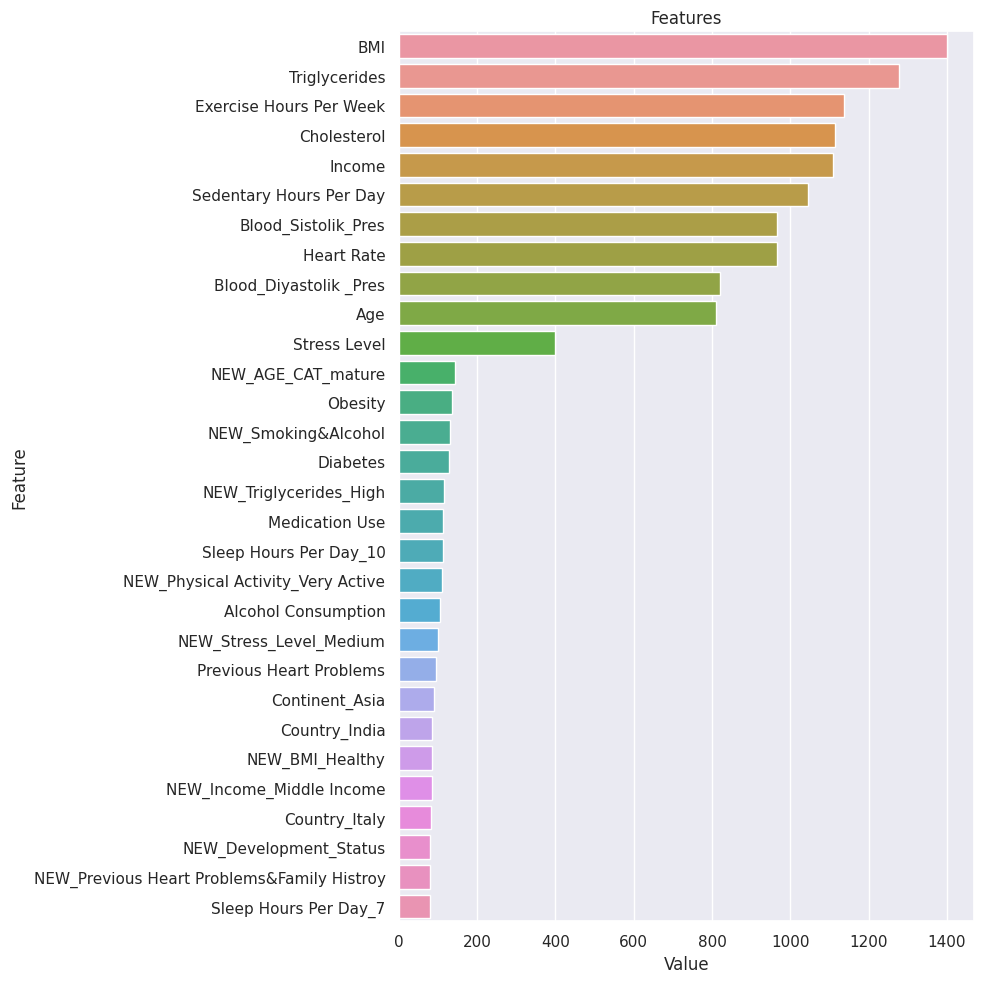

In [14]:
def plot_importance(model, features, num=30, save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")


plot_importance(lgbm_final_model, X)